# Loss functions
  
In Feedbax, each task object—each instance of any type of [`AbstractTask`][feedbax.task.AbstractTask]—must provide a loss function that is used to score performance on that task. Generally, the loss will be calculated based on information in the model state (an instance of some type of `AbstractState`).

??? INFO "Background on loss functions"
    In optimal control, we measure how well a task is performed using a *cost function*. In machine learning, the same concept is called a *loss function*. The larger the value of the loss function, the worse the performance on the task. 

    Loss functions may be composed of multiple *loss terms*, which measure different aspects of performance. Terms are evaluated separately, then (typically) weighted and summed to give the total value of the loss. 

    A movement model generates trajectories of positions, velocities, and forces over time. Loss terms are often quadratic functions which are calculated locally for each time step in a trajectory, then summed or averaged to give the overall value for the loss term across the entire trajectory, prior to its being added to the other loss terms. 
    
    For example, when controlling a point mass to reach from a starting position to a goal position, the *position error loss* for the entire reach reach might be evaluated like so: at each time step of the reach, take the difference between the current position of the point mass and the goal position, and square it; repeat this at every time step, and sum the results across all timesteps. This value will be larger, the longer and farther the point mass stays away from the goal position.
    
    Some loss terms may only be calculated for a subset of time steps. For a reaching task, we might include a loss term that penalizes the square of the velocity but only on the final time step, because we want the point mass to stop at the goal position rather than simply pass through it. It would not make sense to apply this loss term at time steps in the middle of the reach, when the point mass ought to be moving at a non-zero velocity toward the goal!

Common loss terms, such as [`EffectorPositionLoss`][feedbax.loss.EffectorPositionLoss] and [`EffectorFinalVelocityLoss`][feedbax.loss.EffectorFinalVelocityLoss], are defined in `feedbax.loss`. A loss function with multiple weighted terms can be defined in an algebraic manner.


In [ ]:
from feedbax.loss import (
    EffectorFinalVelocityLoss,
    EffectorPositionLoss,
    NetworkActivityLoss,
    NetworkOutputLoss,
)

loss_func = (
    1.0 * EffectorPositionLoss()
    + 1.0 * EffectorFinalVelocityLoss()
    + 1e-5 * NetworkOutputLoss()
    + 1e-5 * NetworkActivityLoss()
)

This is easy to read, and—visually—close to the mathematics.

Typically, after constructing a loss we'll pass it to a task object we're constructing. For example:

```python
task = SimpleReaches(loss_func=loss_func, ...)
```

Feedbax is flexible about how losses are constructed. The following achieves the same result we did above.

In [ ]:
from feedbax.loss import CompositeLoss


loss_func = CompositeLoss(
    dict(
        effector_position=EffectorPositionLoss(),
        effector_final_velocity=EffectorFinalVelocityLoss(),
        nn_output=NetworkOutputLoss(),
        nn_hidden=NetworkActivityLoss(),
    ),
    weights=dict(
        effector_position=1.0,
        effector_final_velocity=1.0,
        nn_output=1e-5,
        nn_hidden=1e-5,
    ),
)

loss_func = CompositeLoss(
    [
        EffectorPositionLoss(),
        EffectorFinalVelocityLoss(),
        NetworkOutputLoss(),
        NetworkActivityLoss(),
    ],
    weights=[1.0, 1.0, 1e-5, 1e-5],
)

`CompositeLoss` allows us to group multiple terms into a single loss function—actually, it's what's constructed in the background when we write the loss function in algebraic form, like we did previously.

The two approaches can be mixed together.

In [ ]:
loss_func = CompositeLoss(
    [
        EffectorPositionLoss(),
        EffectorFinalVelocityLoss(),
        NetworkOutputLoss(),
    ],
    weights=[1.0, 1.0, 1e-5],
)

# Add another term onto a composite loss we've already defined.
loss_func_plus = loss_func + 1e-5 * NetworkActivityLoss()

## `LossDict`

When called, all `AbstractLoss` instances return a `LossDict` object. 

To see what this looks like, let's instantiate a model and evaluate it, then calculate the loss.

In [7]:
import jax

from feedbax.xabdeef import point_mass_nn_simple_reaches


key_init, key_eval = jax.random.split(jax.random.PRNGKey(0))
context = point_mass_nn_simple_reaches(key=key_init)
task, model = context.task, context.model

# We won't bother to train the model for this example

states = task.eval(model, key=key_eval)

# the loss function requires both the model states, and the trial information
loss = task.loss_func(states, task.validation_trials)

We can also get losses and states simultaneously.

In [8]:
loss, states = task.eval_with_loss(model, key=key_eval)

AttributeError: 'SimpleReaches' object has no attribute 'eval_with_loss'

A `LossDict` is mostly similar to a regular `dict` and contains values for all the loss terms.

In [9]:
loss

{'effector_final_velocity': Array(0.13916361, dtype=float32),
 'effector_position': Array(14.18485, dtype=float32),
 'nn_hidden': Array(0.00060537, dtype=float32),
 'nn_output': Array(5.836518e-06, dtype=float32)}

However, it also provides the total loss.

In [10]:
loss.total

Array(14.324625, dtype=float32)

At the end of a training run, `TaskTrainer` returns loss history.

In [12]:
model, train_history = context.train(
    n_batches=500,
    batch_size=250,
    log_step=125,
    key=jax.random.PRNGKey(1),
)

compile:   0%|          | 0/1 [00:00<?, ?it/s]

Training step compiled.
Validation step compiled.


train batch:   0%|          | 0/500 [00:00<?, ?it/s]


Training iteration: 0
	training loss: 3.56e+01
	validation loss: 6.55e+00

Training iteration: 125
	training loss: 1.89e-02
	validation loss: 3.26e-03

Training iteration: 250
	training loss: 6.80e-03
	validation loss: 1.33e-03

Training iteration: 375
	training loss: 5.71e-03
	validation loss: 1.02e-03

Training iteration: 499
	training loss: 4.47e-03
	validation loss: 8.84e-04

Completed training run on a total of 125,000 trials.


A `LossDict` is part of the `TaskTrainerHistory` object.

In [18]:
import equinox as eqx

eqx.tree_pprint(train_history.loss)

{
  'effector_final_velocity':
  f32[500],
  'effector_position':
  f32[500],
  'nn_hidden':
  f32[500],
  'nn_output':
  f32[500]
}


Note that in this case, each loss term is a vector containing a history of the loss term's value across the training run.

(<Figure size 1000x600 with 1 Axes>,
 <Axes: xlabel='Training iteration', ylabel='Loss'>)

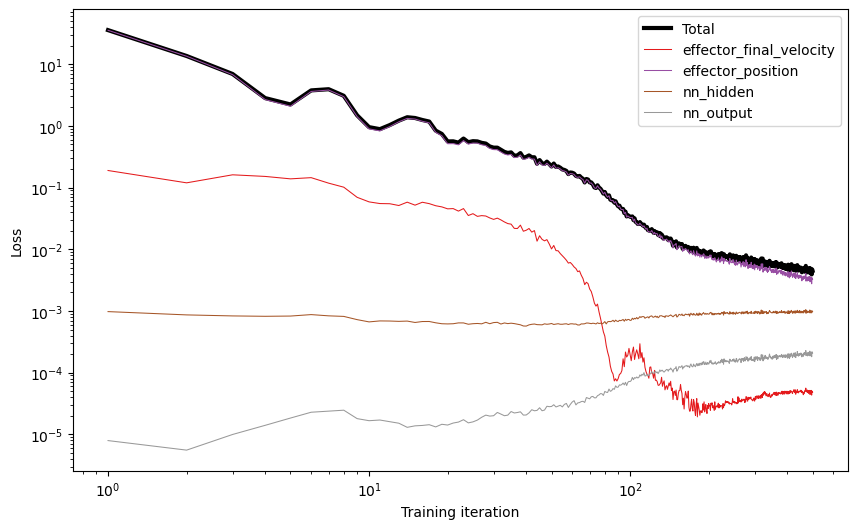

In [20]:
from feedbax.plot import plot_losses

plot_losses(train_history)

## Writing a new loss term

We can write new loss terms by subclassing `AbstractLoss`. To do so, we need to implement the `label` field and the `term` method. 

The `label` is just a string that will be used to identify the loss term, for example in the legend of a loss history plot.

As arguments, the `term` method takes the state history and the trial specifications, and can calculate the loss from any part(s) of those. It returns the loss as a JAX array. Generally this array will contain just one dimension, corresponding to the batch of trials on which the loss is being evaluated—in other words, it returns a scalar for each trial in the batch. Note that it's generally unnecessary in `term` to refer explicitly to the batch dimension.

Any other dimensions (such as time) should be eliminated before returning. Some loss terms will only calculate a loss for a single time step, whereas others will need to aggregate (for example, take the sum of) values calculated for multiple time steps.

The following is a mock example of a typical subclass of `AbstractLoss`. 

!!! NOTE
    For the sake of explicitness, type hints are included for the arguments (`AbstractState`, `AbstractTaskTrialSpec`) and return value (`Array`) of `term`, but these are not strictly needed.

In [ ]:
from typing import Optional

import jax.numpy as jnp
from jaxtyping import Array

from feedbax.loss import AbstractLoss
from feedbax.state import AbstractState
from feedbax.task import AbstractTaskTrialSpec


class SomethingLoss(AbstractLoss):
    """

    """
    label: str = "effector_position"

    def term(
        self,
        states: AbstractState,
        trial_specs: AbstractTaskTrialSpec,
    ) -> Array:

        # Sum over length of variable vector
        loss = jnp.sum(
            (states.some_variable - trial_specs.some_target) ** 2,
            axis=-1
        )

        # Sum over time (if calculated for multiple time steps)
        loss = jnp.sum(loss, axis=-1)

        return loss